# Initial EDA for Points per Shot
Shooting data analysis for 2013-14 through 2019-2020 NBA seasons

In [182]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import nba_api.stats.endpoints as endpoints
from nba_api.stats.static import players

In [183]:
pd.set_option('display.max_columns', None)

In [184]:
all_players = players.get_players()

In [190]:
active_players = [
    f"{player['last_name']}, {player['first_name']}" for player in all_players if player['is_active'] == True
]

## API codes and dataset organization
- **Season IDs**:
    - 1st Digit: 1 = Preseason, 2 = Regular season, 4 = Playoffs
    - Last 4 Digits: Start year of season
    - Data available from 2013-14 through 2019-20 seasons
    
- **PlayerDashPtShots datasets from resultSets**:
    - 0: Overall Shooting
    - 1: General Shooting
    - 2: Shot Clock Shooting
    - 3: Dribble Shooting
    - 4: Closest Defender Shooting
    - 5: Closest Defender 10 feet+ Shooting (mid-range+)
    - 6: Touch Time Shooting

- **Additional Parameters**:
    - team_id: set to 0 for all teams
    - player_id: set to 0 for all players

In [12]:
# Set seasons from 2013-14 through 2019-20 seasons
seasons = [ f'20{i}-{i+1}' for i in range(13, 20) ]
seasons

['2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']

In [ ]:
# Get player shooting from 10+ feet
results = [
    endpoints.playerdashptshots.PlayerDashPtShots(team_id=0, player_id=0, season=season).get_data_frames()[5]
    for season in seasons
]

In [133]:
# Add season to DataFrames
for i in range(len(seasons)):
    results[i]['season'] = seasons[i]

In [134]:
# Concat all results
df = pd.concat([ result for result in results ])

In [135]:
df.head()

,PLAYER_ID,PLAYER_NAME_LAST_FIRST,SORT_ORDER,GP,G,CLOSE_DEF_DIST_RANGE,FGA_FREQUENCY,FGM,FGA,FG_PCT,EFG_PCT,FG2A_FREQUENCY,FG2M,FG2A,FG2_PCT,FG3A_FREQUENCY,FG3M,FG3A,FG3_PCT,season
0,2406,"Butler, Caron",1,1226,14,0-2 Feet - Very Tight,0.0,2,18,0.111,0.111,0.0,2,15,0.133,0.0,0,3,0.000,2013-14
1,201229,"Tolliver, Anthony",1,1226,3,0-2 Feet - Very Tight,0.0,0,4,0.000,0.000,0.0,0,1,0.000,0.0,0,3,0.000,2013-14
2,203148,"Roberts, Brian",1,1226,16,0-2 Feet - Very Tight,0.0,10,21,0.476,0.476,0.0,10,18,0.556,0.0,0,3,0.000,2013-14
3,203095,"Fournier, Evan",1,1226,12,0-2 Feet - Very Tight,0.0,1,13,0.077,0.077,0.0,1,12,0.083,0.0,0,1,0.000,2013-14
4,200782,"Tucker, P.J.",1,1226,9,0-2 Feet - Very Tight,0.0,3,10,0.300,0.400,0.0,1,3,0.333,0.0,2,7,0.286,2013-14


## Shot Selection by Season

In [156]:
# Group by season
data = df.groupby(['season'])['FG2M', 'FG2A', 'FG3M', 'FG3A'].sum().reset_index()

# Unpivot DataFrame from wide to long
data = pd.melt(
    data,
    id_vars=['season'],
    value_vars=['FG2A', 'FG3A'],
    var_name='Shot Type',
    value_name='Attempts',
)

/Users/waynelam/nba/nba_player_pos/nba_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [157]:
data.head()

,season,Shot Type,Attempts
0,2013-14,FG2A,59244
1,2014-15,FG2A,58168
2,2015-16,FG2A,56308
3,2016-17,FG2A,52033
4,2017-18,FG2A,46934


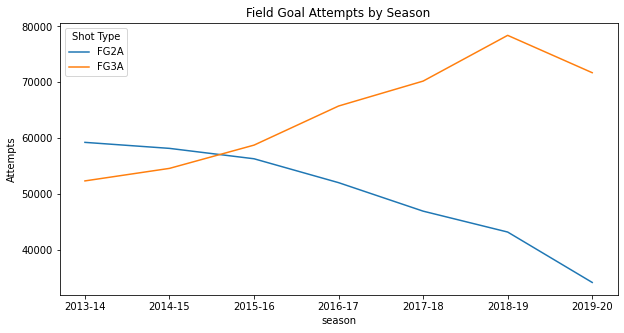

In [158]:
plt.figure(figsize=(10,5))
sns.lineplot(data=data, x='season', y='Attempts', hue='Shot Type', err_style=None)
plt.title('Field Goal Attempts by Season')
plt.show()

In [163]:
# Group by closest defender distance
data = df.groupby(['CLOSE_DEF_DIST_RANGE'])['FG2M', 'FG2A', 'FG3M', 'FG3A'].sum().reset_index()

# Unpivot DataFrame from wide to long
data = pd.melt(
    data,
    id_vars=['CLOSE_DEF_DIST_RANGE'],
    value_vars=['FG2A', 'FG3A'],
    var_name='Shot Type',
    value_name='Attempts',
)

# Rename column
data = data.rename(columns={
    'CLOSE_DEF_DIST_RANGE': 'Closest Defender',
})

/Users/waynelam/nba/nba_player_pos/nba_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [164]:
data.head()

,Closest Defender,Shot Type,Attempts
0,0-2 Feet - Very Tight,FG2A,18589
1,2-4 Feet - Tight,FG2A,118929
2,4-6 Feet - Open,FG2A,143700
3,6+ Feet - Wide Open,FG2A,68837
4,0-2 Feet - Very Tight,FG3A,5422


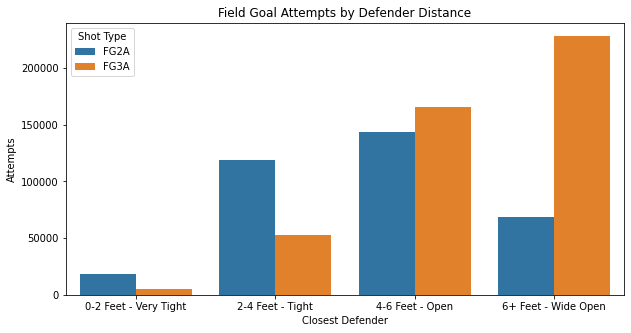

In [169]:
plt.figure(figsize=(10,5))
sns.barplot(data=data, x='Closest Defender', y='Attempts', hue='Shot Type')
plt.title('Field Goal Attempts by Defender Distance')
plt.show()

## Points per Shot (PPS) Evaluation

### Relation between closest defender distance and PPS

In [74]:
# Group shooting PPS by defender distance
data = df.groupby('CLOSE_DEF_DIST_RANGE')['FG2M', 'FG2A', 'FG3M', 'FG3A'].sum()
data['mid'] = data['FG2M'] / data['FG2A'] * 2
data['three'] = data['FG3M'] / data['FG3A'] * 3
data['tenplus'] = (data['FG2M']*2 + data['FG3M']*3) / (data['FG2A'] + data['FG3A'])
data.reset_index(inplace=True)
data

/Users/waynelam/nba/nba_player_pos/nba_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,CLOSE_DEF_DIST_RANGE,FG2M,FG2A,FG3M,FG3A,mid,three,tenplus
0,0-2 Feet - Very Tight,7273,18589,1389,5422,0.782506,0.768536,0.779351
1,2-4 Feet - Tight,45892,118929,15709,52698,0.771755,0.894284,0.809377
2,4-6 Feet - Open,60227,143700,57050,165443,0.838232,1.034495,0.943266
3,6+ Feet - Wide Open,30615,68837,87709,228184,0.889493,1.153135,1.092034


In [99]:
mid_pps = data['FG2M'].sum() / data['FG2A'].sum() * 2
three_pps = data['FG3M'].sum() / data['FG3A'].sum() * 3
print(f'Midrange PPS: {mid_pps}')
print(f'3-Pointer PPS: {three_pps}')

Midrange PPS: 0.8227678507663082
3-Pointer PPS: 1.074873767839078


In [75]:
# Unpivot data from wide to long
pps = pd.melt(
    data,
    id_vars='CLOSE_DEF_DIST_RANGE',
    value_vars=['mid', 'three', 'tenplus'],
    var_name='Shot Type',
    value_name='PPS',
)

# Rename column
pps.rename(columns={'CLOSE_DEF_DIST_RANGE': 'Defender Distance'}, inplace=True)
pps

,Defender Distance,Shot Type,PPS
0,0-2 Feet - Very Tight,mid,0.782506
1,2-4 Feet - Tight,mid,0.771755
2,4-6 Feet - Open,mid,0.838232
3,6+ Feet - Wide Open,mid,0.889493
4,0-2 Feet - Very Tight,three,0.768536
5,2-4 Feet - Tight,three,0.894284
6,4-6 Feet - Open,three,1.034495
7,6+ Feet - Wide Open,three,1.153135
8,0-2 Feet - Very Tight,tenplus,0.779351
9,2-4 Feet - Tight,tenplus,0.809377


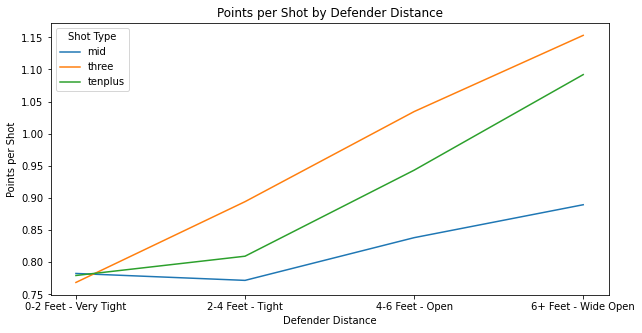

In [76]:
plt.figure(figsize=(10,5))
sns.lineplot(data=pps, x='Defender Distance', y='PPS', hue='Shot Type')
plt.ylabel('Points per Shot')
plt.legend(title='Shot Type')
plt.title('Points per Shot by Defender Distance')
plt.show()

#### Is there a difference between shooting percentages of midrange shots with closest defender tightly guarding or very tightly guarding shooter?

- $p_1=$ proportion of shots made (very tightly guarded)
- $p_2=$ proportion of shots made (tightly guarded)
- $\alpha=0.05$
- $H_0: p_1-p_2=0$ 
- $H_a: p_1-p_2\neq0$

In [100]:
x_a = data['FG2M'][0]
x_b = data['FG2M'][1]
n_a = data['FG2A'][0]
n_b = data['FG2A'][1]
p_a = x_a / n_a
p_b = x_b / n_b
p_c = (x_a + x_b) / (n_a + n_b)

se = np.sqrt(p_c * (1 - p_c) * (1/n_a + 1/n_b))
z = (p_a - p_b) / se

# 2-tailed
alpha = 0.05
p = scipy.stats.norm.sf(abs(z)) * 2
if p < alpha:
    print(f'Statistically significant: p-value={p}')
else:
    print(f'Not statistically significant: p-value={p}')

Not statistically significant: p-value=0.16162176052057942


### Player PPS by Shot Type

In [209]:
# Group by season and player
data = df.groupby(['PLAYER_NAME_LAST_FIRST', 'season'])['FG2M', 'FG2A', 'FG3M', 'FG3A'].sum()
data.reset_index(inplace=True)

# Create PPS features
data['mid'] = data['FG2M'] / data['FG2A'] * 2
data['three'] = data['FG3M'] / data['FG3A'] * 3

# Convert NaN values
for cat in ['mid', 'three']:
    data[cat] = np.where(data[cat].isna(), 0, data[cat])

/Users/waynelam/nba/nba_player_pos/nba_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [210]:
# By player DataFrame
by_player = data.groupby('PLAYER_NAME_LAST_FIRST')['FG2M', 'FG2A', 'FG3M', 'FG3A'].sum().reset_index()
by_player['mid'] = by_player['FG2M'] / by_player['FG2A'] * 2
by_player['three'] = by_player['FG3M'] / by_player['FG3A'] * 3
for cat in ['mid', 'three']:
    by_player[cat] = np.where(by_player[cat].isna(), 0, by_player[cat])

/Users/waynelam/nba/nba_player_pos/nba_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [211]:
# Limit to active players
active = by_player.loc[by_player['PLAYER_NAME_LAST_FIRST'].isin(active_players)]

# Limit to players who have taken midrange 2s and 3s
active = active.loc[(active['FG2A'] != 0) &(active['FG3A'] != 0)]

In [212]:
# All active players who have taken midrange 2s and 3s
len(active)

494

In [213]:
# Subset of players who generate equal or greater PPS from midrange 2s
mid_better = active.loc[active['mid'] >= active['three']]['PLAYER_NAME_LAST_FIRST']
len(mid_better)

73

In [230]:
# Seasonal shooting data by mid_better subset
mb = data.loc[data['PLAYER_NAME_LAST_FIRST'].isin(mid_better)].groupby('season')['FG2M', 'FG2A', 'FG3M', 'FG3A'].sum()
mb.reset_index(inplace=True)

# Make totals
mb['FGA'] = mb['FG2A'] + mb['FG3A']

/Users/waynelam/nba/nba_player_pos/nba_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [231]:
mb

,season,FG2M,FG2A,FG3M,FG3A,FGA
0,2013-14,565,1408,50,171,1579
1,2014-15,455,1187,49,191,1378
2,2015-16,664,1694,42,213,1907
3,2016-17,632,1694,86,352,2046
4,2017-18,831,2084,120,528,2612
5,2018-19,758,2041,144,715,2756
6,2019-20,607,1552,304,1259,2811


In [232]:
# Wide to long
mb_plot = pd.melt(
    mb,
    id_vars='season',
    value_vars=['FG2A', 'FG3A', 'FGA'],
    var_name='Shot Type',
    value_name='Attempts',
)

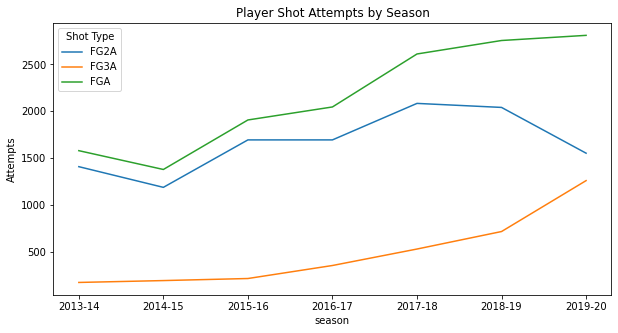

In [233]:
plt.figure(figsize=(10,5))
sns.lineplot(data=mb_plot, x='season', y='Attempts', hue='Shot Type')
plt.title('Player Shot Attempts by Season')
plt.show()

In [236]:
# PPS feature
mb['mid'] = mb['FG2M'] / mb['FG2A'] * 2
mb['three'] = mb['FG3M'] / mb['FG3A'] * 3

In [238]:
# Wide to long
mb_plot = pd.melt(
    mb,
    id_vars='season',
    value_vars=['mid', 'three'],
    var_name='Shot Type',
    value_name='PPS',
)

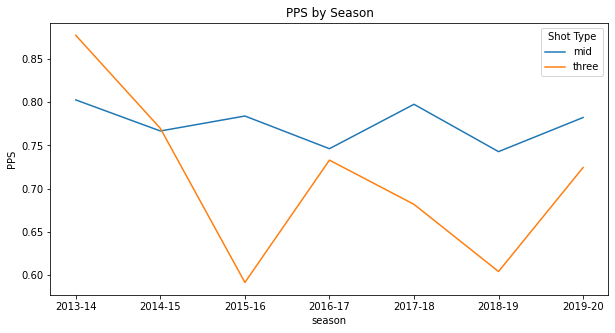

In [239]:
plt.figure(figsize=(10,5))
sns.lineplot(data=mb_plot, x='season', y='PPS', hue='Shot Type')
plt.title('PPS by Season')
plt.show()